# AGGLOMERATIVE HIERARCHICAL CLUSTERING (AHC) - PYTHON CODE IMPLEMENTATION

Dataset: Mall Customers


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mall-customers-datacsv/Mall_Customers.csv


# STEP 1: DATA PRE-PROCESSING

**Purpose:** Prepare the data for clustering analysis

**Key Components:**
* Data Loading: Read the Mall_Customers.csv file
* Data Exploration: Check shape, missing values, data types, statistical summary
* Feature Selection: Choose numerical features (Age, Annual Income, Spending Score)
* Feature Scaling: Apply StandardScaler to normalize different scales

**Why Scaling is Critical:**
- Age (18-70), Income (15-137k), Spending (1-99) have different ranges
- Hierarchical clustering uses distance metrics (Euclidean)
- Without scaling, income would dominate the clustering due to larger value

##  1.1 Load the dataset

In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/mall-customers-datacsv/Mall_Customers.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Dataset loaded successfully!
Dataset shape: (250, 5)

First 5 rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


## 1.2 Explore the dataset


In [4]:
# Basic information about the dataset
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              250 non-null    int64 
 1   Gender                  250 non-null    object
 2   Age                     250 non-null    int64 
 3   Annual Income (k$)      250 non-null    int64 
 4   Spending Score (1-100)  250 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 9.9+ KB
None


In [5]:
# Statistical summary
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
       CustomerID        Age  Annual Income (k$)  Spending Score (1-100)
count  250.000000  250.00000          250.000000              250.000000
mean   125.500000   38.49200           95.592000               50.244000
std     72.312977   13.17026           77.308758               27.289914
min      1.000000   18.00000           15.000000                1.000000
25%     63.250000   29.00000           47.000000               27.000000
50%    125.500000   36.00000           70.000000               50.000000
75%    187.750000   47.75000          101.000000               74.000000
max    250.000000   70.00000          325.000000               99.000000


In [6]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [7]:
# Check data types
print("\nData Types:")
print(df.dtypes)


Data Types:
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


**Dataset Overview:**
- 250 customers with complete data (no missing values)
- 5 features: CustomerID, Gender, Age, Annual Income (k$), and Spending Score (1-100)
- Clean dataset with appropriate data types

Key Insights:
- Age distribution: Customers range from 18-70 years old (mean ≈ 39 years)
- Income distribution: Annual income varies widely from $15k-$137k (mean ≈ $60.6k)
- Spending behavior: Spending scores are well-distributed from 1-99 (mean ≈ 50.2)

## 1.3 Data Cleaning and Preparation

In [8]:
# Remove CustomerID as it's not useful for clustering
print("Original columns:", df.columns.tolist())

Original columns: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [9]:
# Handle categorical variables (Gender)
# Create dummy variables
df_encoded = pd.get_dummies(df, columns=['Gender'], prefix='Gender')
print("After encoding Gender:", df_encoded.columns.tolist())

After encoding Gender: ['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Female', 'Gender_Male']


- Converts categorical 'Gender' column into binary columns
- Creates 'Gender_Female' and 'Gender_Male' columns (one-hot encoding)
- Original 'Gender' column is replaced
- DataFrame now has 6 columns instead of 5

In [10]:
# For this example, we'll focus on numerical features only
# Select only numerical features for clustering
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X = df[numerical_features].copy()
print(f"\nSelected features for clustering: {numerical_features}")
print(f"Feature matrix shape: {X.shape}")


Selected features for clustering: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Feature matrix shape: (250, 3)


## 1.4 Feature Scaling

In [11]:
# Display original data statistics
print("Original data statistics:")
print(X.describe())

Original data statistics:
             Age  Annual Income (k$)  Spending Score (1-100)
count  250.00000          250.000000              250.000000
mean    38.49200           95.592000               50.244000
std     13.17026           77.308758               27.289914
min     18.00000           15.000000                1.000000
25%     29.00000           47.000000               27.000000
50%     36.00000           70.000000               50.000000
75%     47.75000          101.000000               74.000000
max     70.00000          325.000000               99.000000


Showing the different scales of features before normalization

**Key observations:**
- Age: ranges from 18-70 (mean ~39)
- Annual Income: ranges from 15-137k (mean ~60.6k)
- Spending Score: ranges from 1-99 (mean ~50.2)

Problem: Features have vastly different scales, which can bias distance-based clustering

In [12]:
# Apply StandardScaler to normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

What the StandardScaler does:
- Standardizes features by removing mean and scaling to unit variance
- Formula: z = (x - μ) / σ
- Each feature will have mean=0 and std=1

In [13]:
# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_features)
print("\nScaled data statistics:")
print(X_scaled_df.describe())


Scaled data statistics:
                Age  Annual Income (k$)  Spending Score (1-100)
count  2.500000e+02        2.500000e+02            2.500000e+02
mean   1.989520e-16        5.684342e-17            3.197442e-17
std    1.002006e+00        1.002006e+00            1.002006e+00
min   -1.559051e+00       -1.044560e+00           -1.808096e+00
25%   -7.221604e-01       -6.298054e-01           -8.534519e-01
50%   -1.895937e-01       -3.317003e-01           -8.958968e-03
75%    7.043575e-01        7.009359e-02            8.722510e-01
max    2.397159e+00        2.973378e+00            1.790178e+00


The esults confirm:
- All features now have mean ≈ 0
- All features now have std = 1
- Same number of samples (250) available

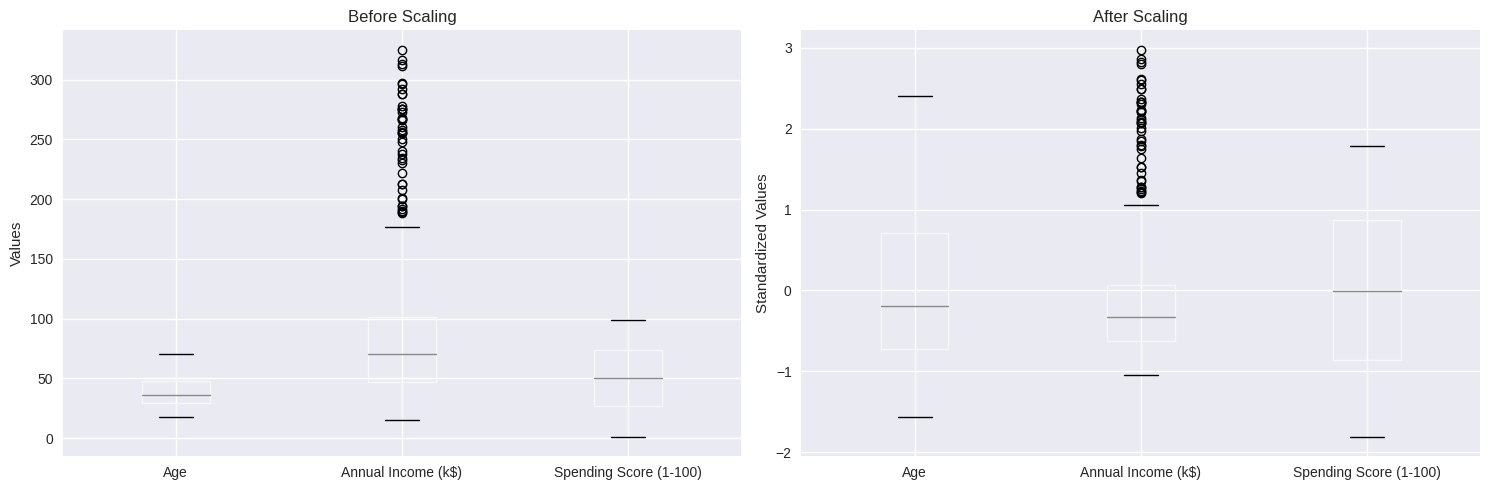

Feature scaling completed!
Note: Scaling is important for hierarchical clustering as it uses distance metrics


In [21]:
# Visualize the effect of scaling
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before scaling
X.boxplot(ax=axes[0])
axes[0].set_title('Before Scaling')
axes[0].set_ylabel('Values')

# After scaling
X_scaled_df.boxplot(ax=axes[1])
axes[1].set_title('After Scaling')
axes[1].set_ylabel('Standardized Values')

plt.tight_layout()
plt.show()

print("Feature scaling completed!")


Note: Scaling is important for hierarchical clustering as it uses distance metrics

Visualization shows:
1. Before: Income values dominate (0-140 range) vs Age (0-70) and Spending Score (0-100)
2. After: All features on same scale (-2 to +3 approximately)

# STEP 2: FINDING OPTIMAL NUMBER OF CLUSTERS USING DENDROGRAM

Creating dendrogram to determine optimal number of clusters

## 2.1 Create Dendrogram


Creating dendrogram to determine optimal number of clusters...


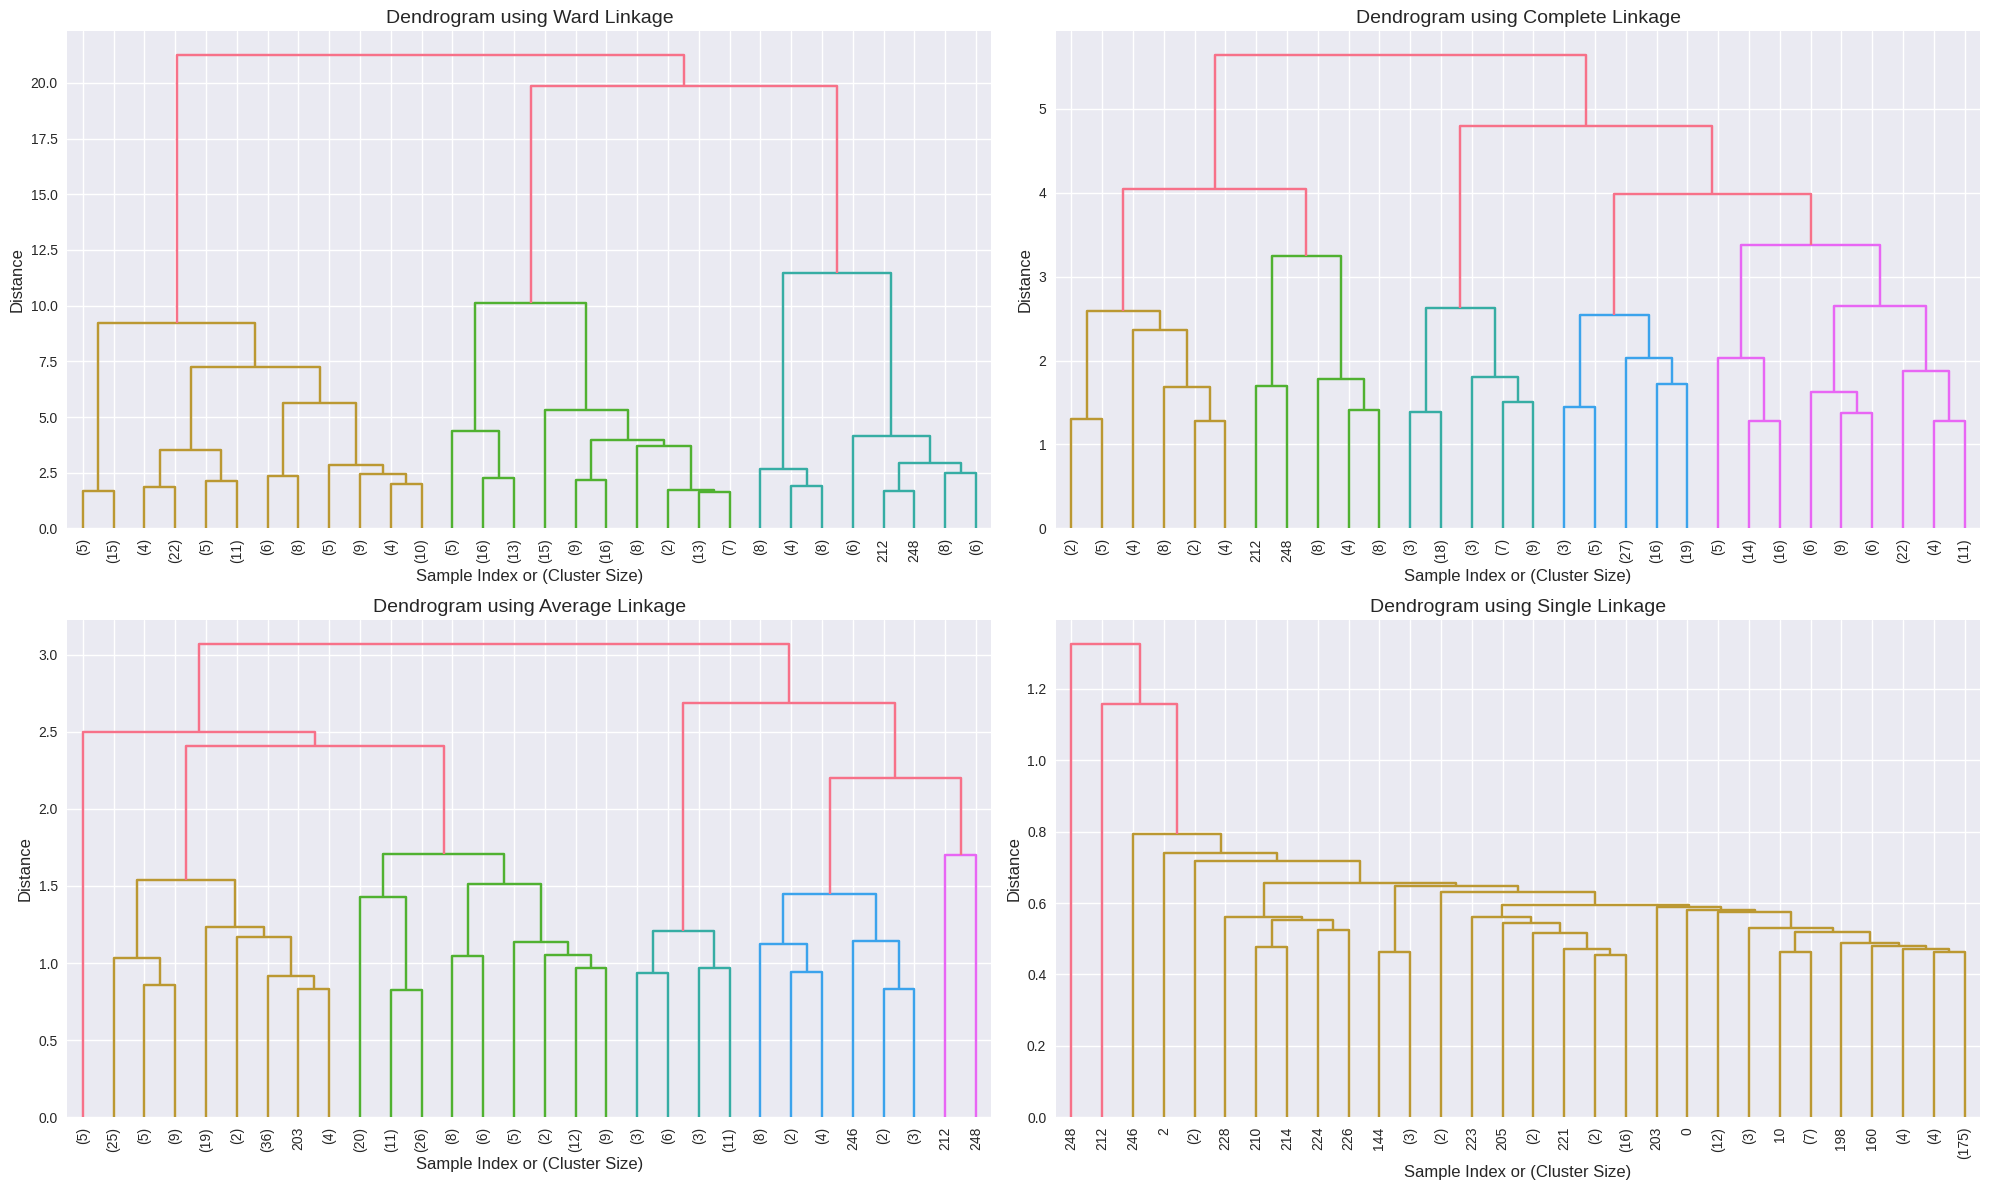

In [22]:
# Creating dendrogram to determine optimal number of clusters

# Calculate linkage matrix using different methods
linkage_methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Calculate linkage matrix
    linkage_matrix = linkage(X_scaled, method=method)
    
    # Create dendrogram
    dendrogram(linkage_matrix, 
               ax=axes[i],
               truncate_mode='lastp',  # Show only last p merged clusters
               p=30,  # Show last 30 merges
               leaf_rotation=90,
               leaf_font_size=10)
    
    axes[i].set_title(f'Dendrogram using {method.capitalize()} Linkage', fontsize=14)
    axes[i].set_xlabel('Sample Index or (Cluster Size)', fontsize=12)
    axes[i].set_ylabel('Distance', fontsize=12)

plt.tight_layout()
plt.show()

Dendrograms help visualize hierarchical clustering and determine the optimal number of clusters by showing how data points merge at different distance levels.

1. Calculate Linkage Matrix
- Computes hierarchical clustering using different linkage methods
- Each method defines how distance between clusters is calculated

2. Create Dendrogram Visualization

Parameters explained:
- truncate_mode='lastp': Simplifies visualization by showing only last 30 merges
- p=30: Number of merges to display
- leaf_rotation=90: Vertical labels for readability



**Linkage Methods Comparison:**

1. Ward Linkage (top-left):
- Minimizes within-cluster variance
- Shows clearest cluster separation with distinct hierarchical structure
- Best for spherical, similar-sized clusters


2. Complete Linkage (Top-right):
- Uses maximum distance between clusters
- Shows good separation but slightly less clear than Ward
- Good for compact clusters


3. Average Linkage (Bottom-left):
- Uses average distance between all pairs
- Shows moderate separation
- Balanced approach


4. Single Linkage (Bottom-right):
- Uses minimum distance between clusters
- Shows chaining effect - poor cluster separation
- Not suitable for this dataset



Key Observations:
- Looking at Ward linkage (best performer), cutting the dendrogram at height ~10 suggests 5 distinct clusters
- Different colors represent different clusters when cut at certain height
- Y-axis (Distance): Shows the distance at which clusters merge
    - Larger jumps in distance indicate more distinct clusters
    - Ward shows clear jumps around distance 10-15



Notes:
Ward linkage is recommended for this dataset based on clear separation. The dendrogram suggests 5 clusters as optimal (visible as 5 major branches). Also, single linkage should be avoided due to the chaining effect.
This dendrogram analysis provides visual evidence for cluster selection, complementing quantitative methods like elbow method.

## 2.2 Detailed analysis with Ward linkage (most commonly used)
Detailed analysis with Ward linkage (most commonly used

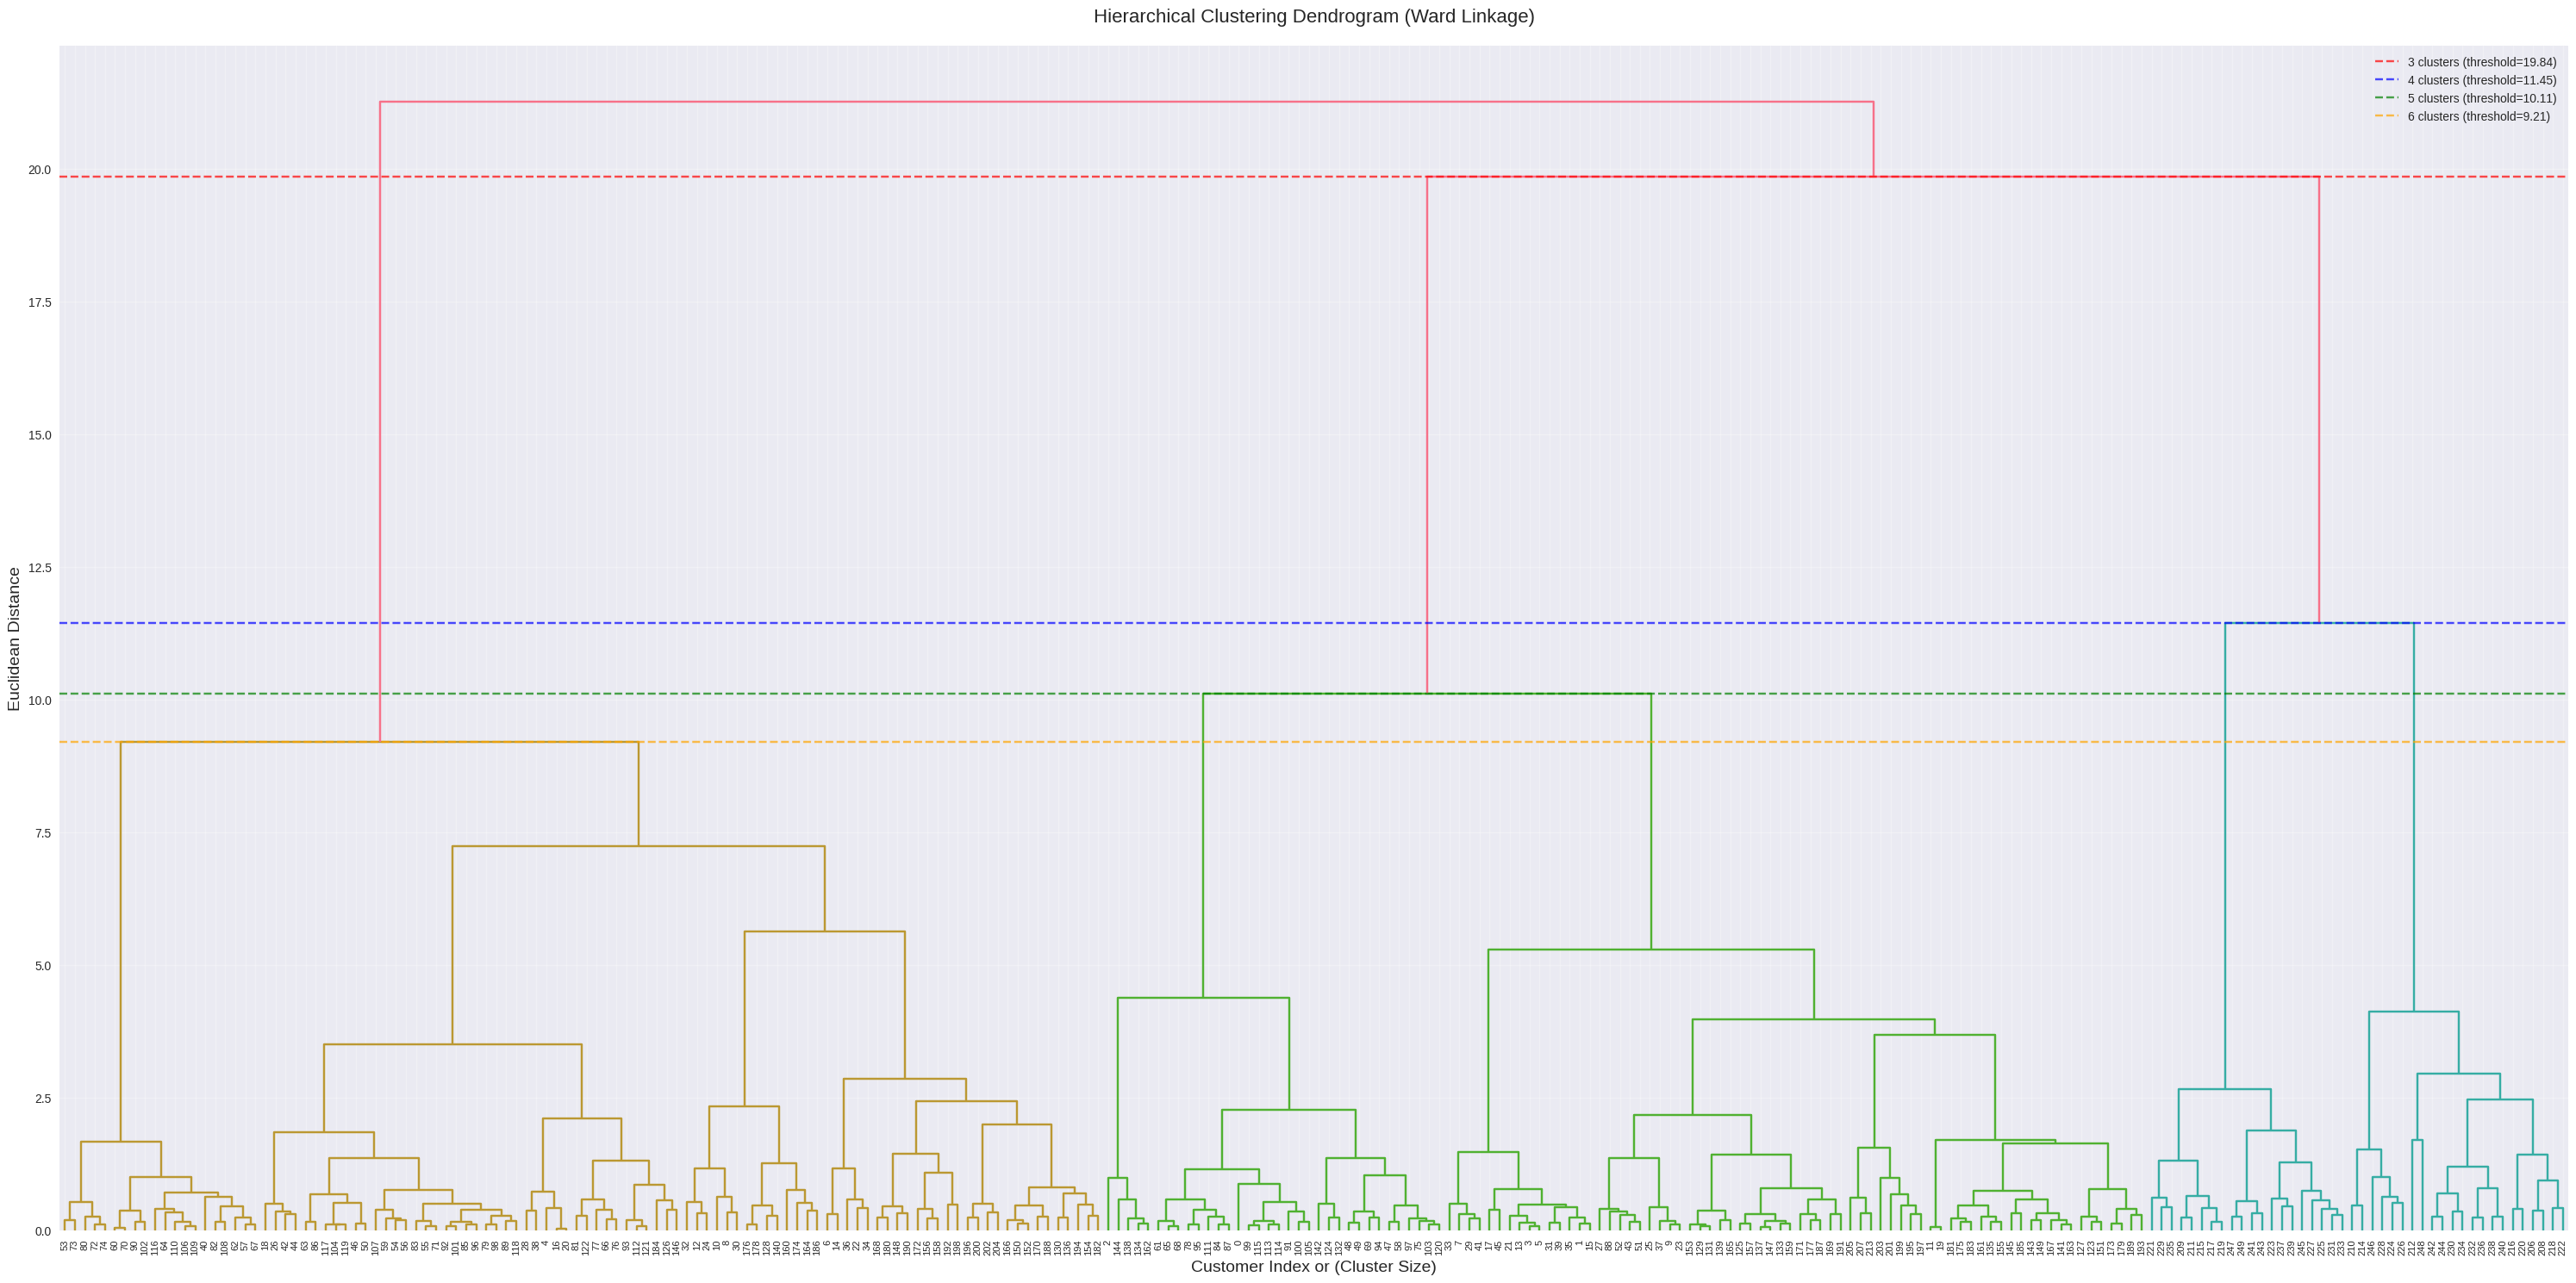

In [24]:
plt.figure(figsize=(30, 15))

# Create linkage matrix using Ward method
linkage_matrix = linkage(X_scaled, method='ward')

# Create detailed dendrogram
dendrogram_plot = dendrogram(linkage_matrix,
                            leaf_rotation=90,
                            leaf_font_size=8,
                            color_threshold=0.7*max(linkage_matrix[:,2]))  # Color threshold

plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=16, pad=20)
plt.xlabel('Customer Index or (Cluster Size)', fontsize=14)
plt.ylabel('Euclidean Distance', fontsize=14)

# Add horizontal lines to show potential cut points
potential_clusters = [3, 4, 5, 6]
colors = ['red', 'blue', 'green', 'orange']

for i, (clusters, color) in enumerate(zip(potential_clusters, colors)):
    # Calculate the distance threshold for desired number of clusters
    threshold = linkage_matrix[-(clusters-1), 2]
    plt.axhline(y=threshold, color=color, linestyle='--', alpha=0.7, 
                label=f'{clusters} clusters (threshold={threshold:.2f})')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Why 5 Clusters is Optimal:
- The distance jump from ~10 to ~20 is the largest in the dendrogram
- This represents the most natural grouping in the data
- More clusters (9) would split groups that are relatively similar
- Fewer clusters (3-4) would merge groups that are quite distinct


Cluster Balance:
- Not perfectly balanced (one large cluster of ~100 samples). This suggests the data has one major customer segment and four smaller, more specialized segments

5 clusters provides the best balance between granularity and interoperability. The uneven cluster sizes suggest different customer segment sizes in the market and this finding strongly supports using k=5 for K-means clustering.

## 2.3 Analyze the linkage matrix to suggest optimal clusters

Optimal cluster analysis

In [25]:
# Calculate the differences in merge distances
distances = linkage_matrix[:, 2]
differences = np.diff(distances)

# Find the largest jumps in distance (elbow method for hierarchical clustering)
print("Last 10 merge distances:")
for i, dist in enumerate(distances[-10:]):
    cluster_num = len(distances) - i
    print(f"Merge to {cluster_num:2d} clusters: distance = {dist:.4f}")

print("\nLargest increases in merge distance (suggesting optimal cut points):")
largest_jumps = np.argsort(differences)[-5:][::-1]
for i, jump_idx in enumerate(largest_jumps):
    clusters_formed = len(distances) - jump_idx
    print(f"Rank {i+1}: {clusters_formed} clusters (distance jump: {differences[jump_idx]:.4f})")


Last 10 merge distances:
Merge to 249 clusters: distance = 4.1277
Merge to 248 clusters: distance = 4.3774
Merge to 247 clusters: distance = 5.2947
Merge to 246 clusters: distance = 5.6299
Merge to 245 clusters: distance = 7.2351
Merge to 244 clusters: distance = 9.2086
Merge to 243 clusters: distance = 10.1105
Merge to 242 clusters: distance = 11.4468
Merge to 241 clusters: distance = 19.8406
Merge to 240 clusters: distance = 21.2542

Largest increases in merge distance (suggesting optimal cut points):
Rank 1: 3 clusters (distance jump: 8.3937)
Rank 2: 6 clusters (distance jump: 1.9735)
Rank 3: 7 clusters (distance jump: 1.6052)
Rank 4: 2 clusters (distance jump: 1.4137)
Rank 5: 4 clusters (distance jump: 1.3363)


In [26]:
# Suggest optimal number of clusters
optimal_clusters = len(distances) - np.argmax(differences) + 1
print(f"\nSuggested optimal number of clusters: {optimal_clusters}")


Suggested optimal number of clusters: 4


# STEP 3: TRAINING THE HIERARCHICAL CLUSTERING MODEL

## 3.1 Train models with different numbers of clusters
Training Agglomerative Clustering models

In [27]:
cluster_range = range(2, 8)  # Test 2 to 7 clusters
models = {}
predictions = {}

for n_clusters in cluster_range:
    print(f"Training model with {n_clusters} clusters...")
    
    # Create and train the model
    model = AgglomerativeClustering(
        n_clusters=n_clusters,
        affinity='euclidean',  # Distance metric
        linkage='ward'         # Linkage method
    )
    
    # Fit the model and predict clusters
    cluster_labels = model.fit_predict(X_scaled)
    
    # Store results
    models[n_clusters] = model
    predictions[n_clusters] = cluster_labels
    
    print(f"Model with {n_clusters} clusters trained successfully!")


Training Agglomerative Clustering models...
Training model with 2 clusters...
Model with 2 clusters trained successfully!
Training model with 3 clusters...
Model with 3 clusters trained successfully!
Training model with 4 clusters...
Model with 4 clusters trained successfully!
Training model with 5 clusters...
Model with 5 clusters trained successfully!
Training model with 6 clusters...
Model with 6 clusters trained successfully!
Training model with 7 clusters...
Model with 7 clusters trained successfully!


## 3.2 Select the final model (let's use 5 clusters as an example)

In [28]:
optimal_n_clusters = 5
print(f"\n" + "-"*40)
print(f"FINAL MODEL: {optimal_n_clusters} CLUSTERS")
print("-"*40)

# Train the final model
final_model = AgglomerativeClustering(
    n_clusters=optimal_n_clusters,
    affinity='euclidean',
    linkage='ward'
)

# Fit and predict
final_predictions = final_model.fit_predict(X_scaled)

print(f"Final model trained with {optimal_n_clusters} clusters")
print(f"Number of samples: {len(final_predictions)}")
print(f"Cluster labels: {np.unique(final_predictions)}")


----------------------------------------
FINAL MODEL: 5 CLUSTERS
----------------------------------------
Final model trained with 5 clusters
Number of samples: 250
Cluster labels: [0 1 2 3 4]


## 3.3 Add cluster labels to original dataset

In [29]:
df_clustered = df.copy()
df_clustered['Cluster'] = final_predictions

print("\nCluster distribution:")
cluster_counts = pd.Series(final_predictions).value_counts().sort_index()
print(cluster_counts)

print(f"\nPercentage distribution:")
cluster_percentages = (cluster_counts / len(final_predictions) * 100).round(2)
for cluster, percentage in cluster_percentages.items():
    print(f"Cluster {cluster}: {percentage}%")


Cluster distribution:
0    104
1     70
2     22
3     20
4     34
Name: count, dtype: int64

Percentage distribution:
Cluster 0: 41.6%
Cluster 1: 28.0%
Cluster 2: 8.8%
Cluster 3: 8.0%
Cluster 4: 13.6%


# STEP 4: VISUALIZING THE CLUSTERS

## 4.1 2D Scatter Plots for different feature combinations
Creating 2D visualization plots

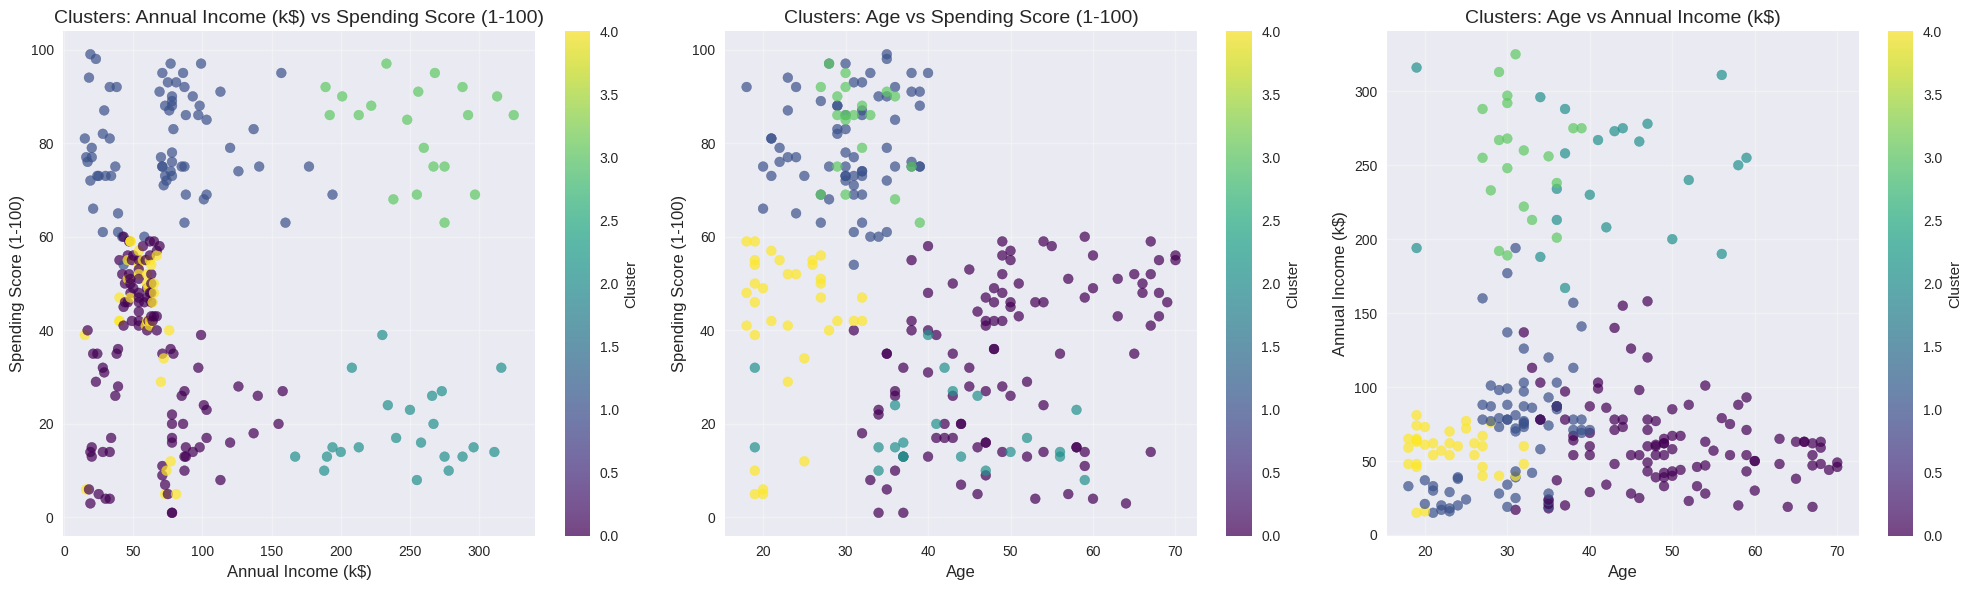

In [30]:
feature_pairs = [
    ('Annual Income (k$)', 'Spending Score (1-100)'),
    ('Age', 'Spending Score (1-100)'),
    ('Age', 'Annual Income (k$)')
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (feature1, feature2) in enumerate(feature_pairs):
    scatter = axes[i].scatter(df_clustered[feature1], 
                             df_clustered[feature2], 
                             c=df_clustered['Cluster'], 
                             cmap='viridis', 
                             alpha=0.7,
                             s=50)
    
    axes[i].set_xlabel(feature1, fontsize=12)
    axes[i].set_ylabel(feature2, fontsize=12)
    axes[i].set_title(f'Clusters: {feature1} vs {feature2}', fontsize=14)
    
    # Add colorbar
    plt.colorbar(scatter, ax=axes[i], label='Cluster')
    
    # Add grid
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.2 3D Visualization
Creating 3D visualization

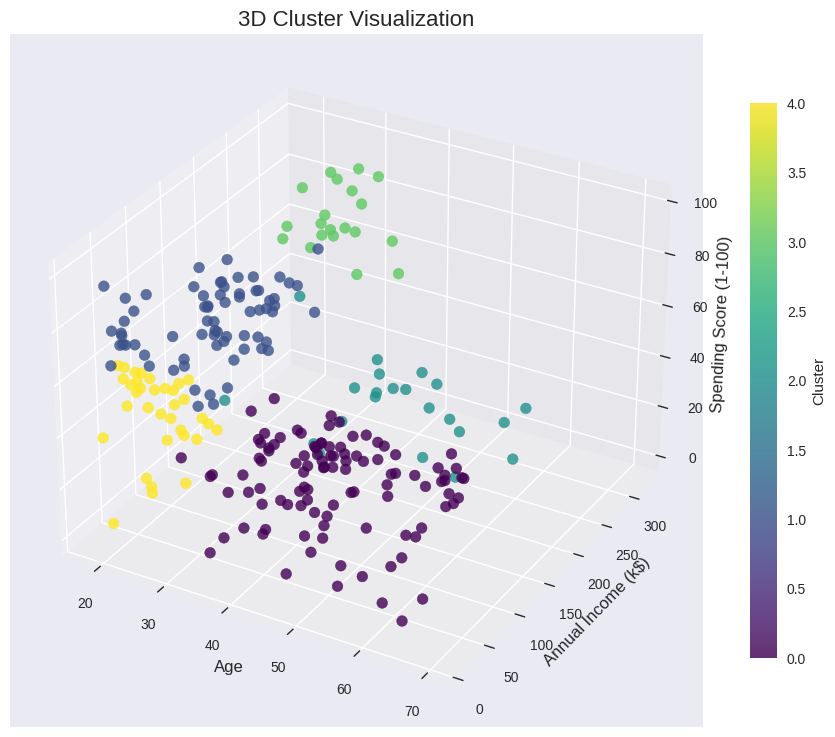

In [31]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Create 3D scatter plot
scatter = ax.scatter(df_clustered['Age'],
                    df_clustered['Annual Income (k$)'],
                    df_clustered['Spending Score (1-100)'],
                    c=df_clustered['Cluster'],
                    cmap='viridis',
                    s=60,
                    alpha=0.8)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Annual Income (k$)', fontsize=12)
ax.set_zlabel('Spending Score (1-100)', fontsize=12)
ax.set_title('3D Cluster Visualization', fontsize=16)

# Add colorbar
plt.colorbar(scatter, ax=ax, shrink=0.8, label='Cluster')

plt.show()

## 4.3 Cluster Analysis and Interpretation

In [32]:
# Calculate cluster statistics
cluster_stats = df_clustered.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Annual Income (k$)': ['mean', 'std'],
    'Spending Score (1-100)': ['mean', 'std'],
    'CustomerID': 'count'
}).round(2)

cluster_stats.columns = ['Age_Mean', 'Age_Std', 'Income_Mean', 'Income_Std', 
                        'Spending_Mean', 'Spending_Std', 'Count']

print("Cluster Characteristics:")
print(cluster_stats)

Cluster Characteristics:
         Age_Mean  Age_Std  Income_Mean  Income_Std  Spending_Mean  \
Cluster                                                              
0           49.61    10.34        62.53       29.26          33.68   
1           30.36     5.46        70.74       40.86          79.44   
2           41.95    10.88       245.32       42.31          18.59   
3           31.55     3.53       255.35       38.76          83.10   
4           23.09     4.32        57.03       15.11          41.94   

         Spending_Std  Count  
Cluster                       
0               17.36    104  
1               10.99     70  
2                8.24     22  
3                9.97     20  
4               16.11     34  


In [33]:
# Gender distribution by cluster
print("\nGender Distribution by Cluster:")
gender_dist = pd.crosstab(df_clustered['Cluster'], df_clustered['Gender'], margins=True)
print(gender_dist)


Gender Distribution by Cluster:
Gender   Female  Male  All
Cluster                   
0            57    47  104
1            39    31   70
2            14     8   22
3             8    12   20
4            19    15   34
All         137   113  250


## 4.4 Cluster Profiles (Interpretation)

In [34]:
for cluster in range(optimal_n_clusters):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
    
    print(f"\n--- CLUSTER {cluster} ({len(cluster_data)} customers) ---")
    print(f"Average Age: {cluster_data['Age'].mean():.1f} years")
    print(f"Average Income: ${cluster_data['Annual Income (k$)'].mean():.1f}k")
    print(f"Average Spending Score: {cluster_data['Spending Score (1-100)'].mean():.1f}/100")
    print(f"Gender Distribution: {cluster_data['Gender'].value_counts().to_dict()}")
    
    # Business interpretation
    avg_income = cluster_data['Annual Income (k$)'].mean()
    avg_spending = cluster_data['Spending Score (1-100)'].mean()
    avg_age = cluster_data['Age'].mean()
    
    if avg_income > 70 and avg_spending > 70:
        profile = "High Income, High Spending (Premium Customers)"
    elif avg_income > 70 and avg_spending < 30:
        profile = "High Income, Low Spending (Potential Target)"
    elif avg_income < 30 and avg_spending > 70:
        profile = "Low Income, High Spending (Impulsive Buyers)"
    elif avg_income < 30 and avg_spending < 30:
        profile = "Low Income, Low Spending (Budget Conscious)"
    else:
        profile = "Moderate Income and Spending (Average Customers)"
    
    print(f"Business Profile: {profile}")


--- CLUSTER 0 (104 customers) ---
Average Age: 49.6 years
Average Income: $62.5k
Average Spending Score: 33.7/100
Gender Distribution: {'Female': 57, 'Male': 47}
Business Profile: Moderate Income and Spending (Average Customers)

--- CLUSTER 1 (70 customers) ---
Average Age: 30.4 years
Average Income: $70.7k
Average Spending Score: 79.4/100
Gender Distribution: {'Female': 39, 'Male': 31}
Business Profile: High Income, High Spending (Premium Customers)

--- CLUSTER 2 (22 customers) ---
Average Age: 42.0 years
Average Income: $245.3k
Average Spending Score: 18.6/100
Gender Distribution: {'Female': 14, 'Male': 8}
Business Profile: High Income, Low Spending (Potential Target)

--- CLUSTER 3 (20 customers) ---
Average Age: 31.6 years
Average Income: $255.3k
Average Spending Score: 83.1/100
Gender Distribution: {'Male': 12, 'Female': 8}
Business Profile: High Income, High Spending (Premium Customers)

--- CLUSTER 4 (34 customers) ---
Average Age: 23.1 years
Average Income: $57.0k
Average Sp

## Summary:


In [35]:
print(f"- Dataset: {df.shape[0]} customers with {len(numerical_features)} features")
print(f"- Optimal clusters: {optimal_n_clusters}")
print(f"- Algorithm: Agglomerative Clustering with Ward linkage")
print(f"- Distance metric: Euclidean")
print("- Features used: Age, Annual Income, Spending Score")
print("- Data preprocessing: StandardScaler normalization")

- Dataset: 250 customers with 3 features
- Optimal clusters: 5
- Algorithm: Agglomerative Clustering with Ward linkage
- Distance metric: Euclidean
- Features used: Age, Annual Income, Spending Score
- Data preprocessing: StandardScaler normalization
